# Project: Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that we will use has been provided by Udacity partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook provides a framework within which we will perform our analysis steps and clearly document our approach so that other scientists can understand the decisions we've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, we will report our findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so we'll need an additional argument in our [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.dtypes.value_counts()

float64    49
int64      32
object      4
dtype: int64

In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
feat_info.shape

(85, 4)

In [10]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to help us make cleaning decisions during this stage of the project. First of all, we should assess the demographics data in terms of missing data.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We'll need to do a little bit of parsing to make use of it to identify and clean the data. We'll convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [11]:
azdias.isna().sum().sum()

4896838

In [12]:
# Identify missing or unknown data values and convert them to NaNs.

# Convert values of missing_or_unknown column from string to list
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('][').split(','))

In [13]:
# Convert missing or unknown data values to NaNs
count = 0
for column, code in zip(azdias, feat_info['missing_or_unknown']):
    
    # Check if the feature has codes for missing or unknown values
    if code[0] != '':
        
        # Convert missing and unknown data to NaNs for object columns
        if azdias[column].dtypes == 'object':
            count += len(azdias[azdias[column].isin(code)])
            azdias[column] = azdias[column].replace(code, np.nan)
        
        # Convert missing and unknown data to NaNs for numeric columns
        else:
            code_c = [eval(x) for x in code] # Convert codes from string to numeric type
            count += len(azdias[azdias[column].isin(code_c)])
            azdias[column] = azdias[column].replace(code_c, np.nan)

In [14]:
print('Total number of data with missing or unknown codes:', count)

Total number of data with missing or unknown codes: 3477091


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? 

There are a few columns that are outliers in terms of the proportion of values that are missing. We will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project we should just remove them from the dataframe.

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Create a dictionary contains column name as key and number of missing data as value
count_nan_dic = azdias.isna().sum().to_dict()

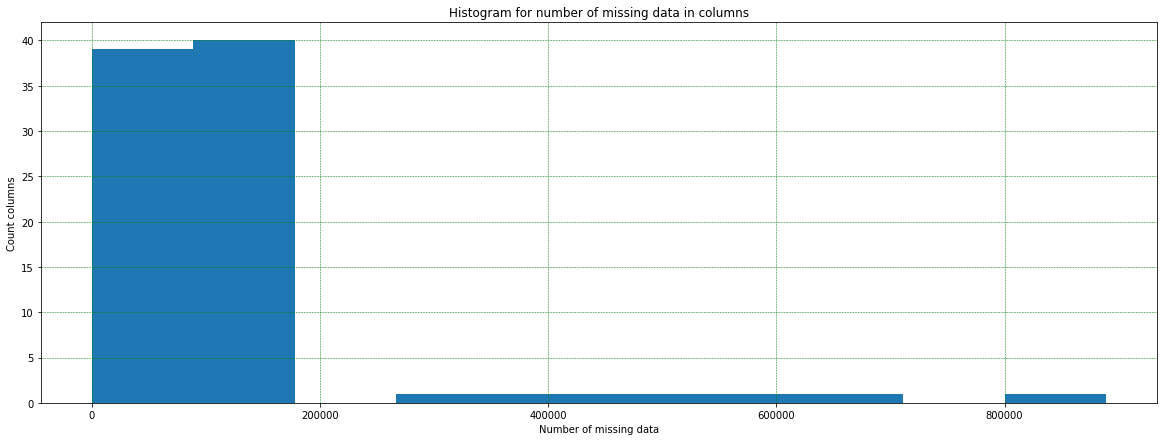

In [16]:
# Investigate patterns in the amount of missing data in each column.

# Plot histogram for the number of missing data in columns
plt.figure(figsize=(20,7))
plt.hist(count_nan_dic.values())
  
plt.title('Histogram for number of missing data in columns')
plt.xlabel('Number of missing data')
plt.ylabel('Count columns')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

plt.show()

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Make a list of all columns' name that have more than 200,000 missing values
drop_col_names = [k for k, v in count_nan_dic.items() if v > 200000]
print('Removed columns from dataset:', drop_col_names)

# Drop outlier columns
azdias.drop(columns=drop_col_names, inplace=True)


Removed columns from dataset: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [18]:
# Print number of features after droping outliers
print('Number of remaining features in in the dataset:', azdias.shape[1])

Number of remaining features in in the dataset: 79


#### Discussion 1.1.2: Assess Missing Data in Each Column

By looking at the histogram of missing data in each column, most of them have a number of missing data between 0 to almost 200,000. As the histogram shows a right-skewed distribution, there are also some outlier columns in terms of missing data. Six columns have been removed from the dataset and their names are listed above.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, we'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? We'll divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. We'll select some of these columns and compare the distribution of values.

- We can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, we might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how we approach our conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on.

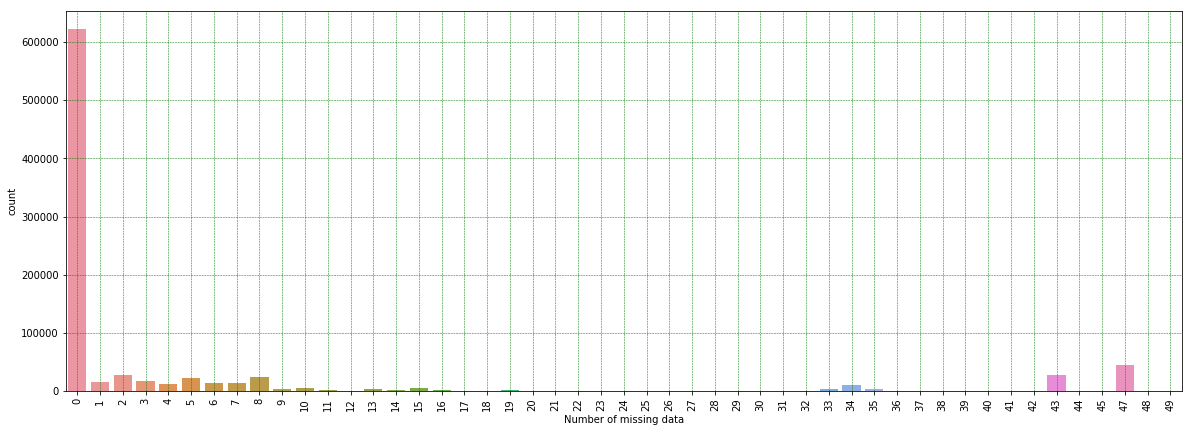

In [19]:
# How much data is missing in each row of the dataset?

# Calculate the number of missing values in each row
miss_val_row = azdias.isna().sum(axis=1)

# Plot the histogram for numbre of missing values in rows
plt.figure(figsize=(20,7))
sns.countplot(miss_val_row)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.xlabel('Number of missing data')
plt.xticks(rotation=90)
plt.show()

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Select two subsets of row with lower than 5 and higher than 20 number of 
# missing values
subset1_index = list(miss_val_row[miss_val_row < 5].index.values)
subset2_index = list(miss_val_row[miss_val_row > 5].index.values)

subset1 = azdias[azdias.index.isin(subset1_index)].copy()
subset2 = azdias[azdias.index.isin(subset2_index)].copy()

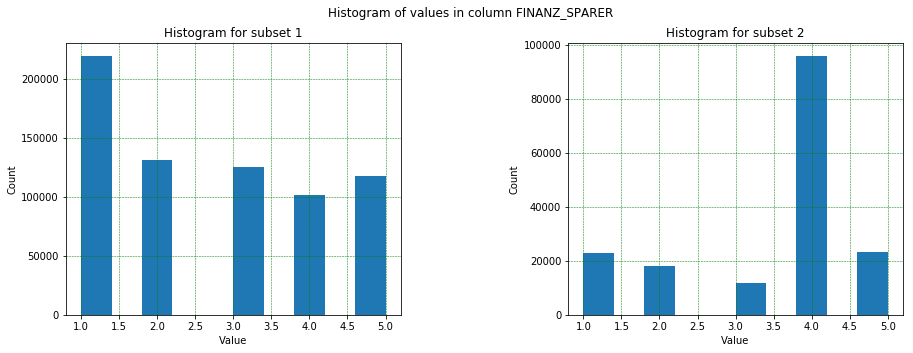

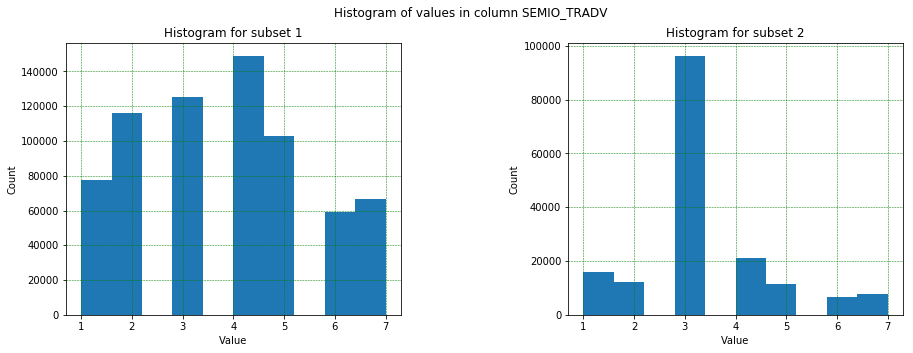

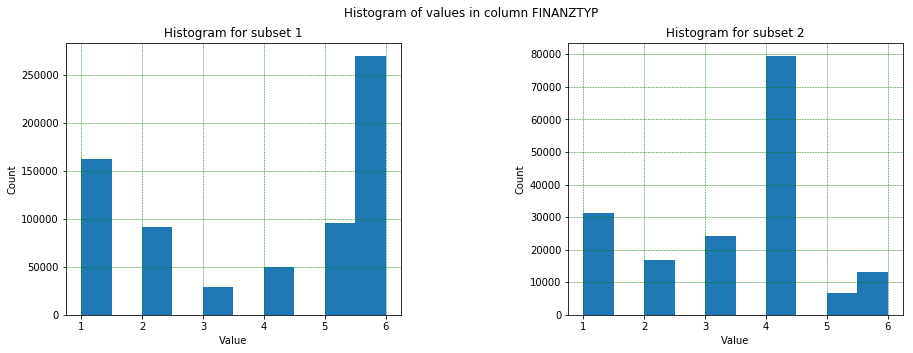

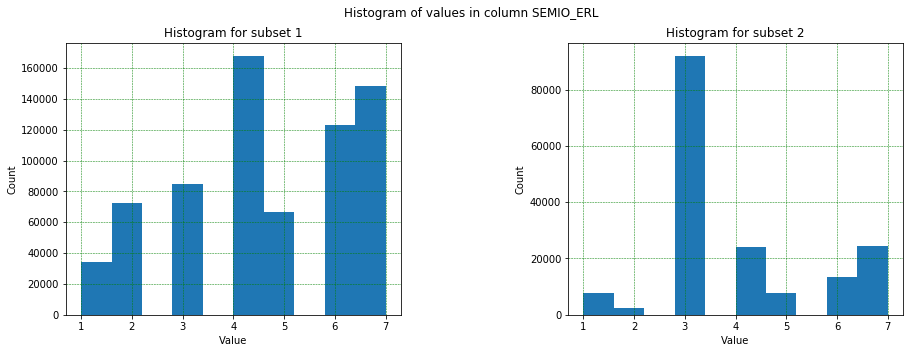

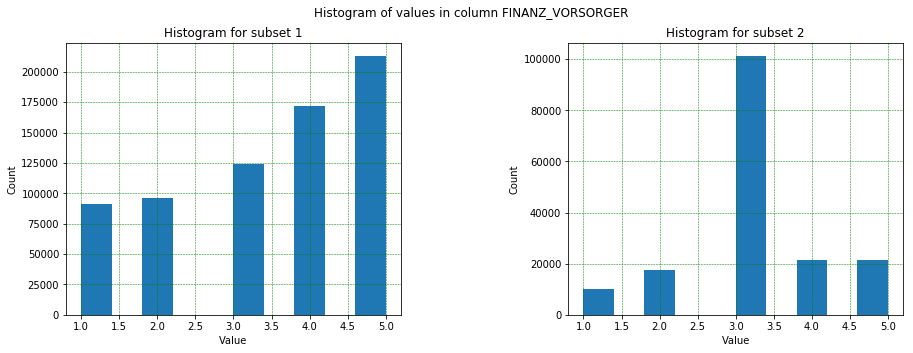

In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Import random to randomly pick 5 columns with no missing values
import random

def plot_distribution(column):
    # The function plots the distribution of values in input column for both subsets
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    fig.suptitle('Histogram of values in column {}'.format(column))
    
    ax1.hist(subset1[column])
    #sns.histplot(data=subset1[column], kde=True, stat='density', ax=ax1)
    #sns.countplot(ax=ax1, data=subset1[column])
    ax1.set_title('Histogram for subset 1'.format(column))
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Count')
    ax1.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    
    ax2.hist(subset2[column])
    #sns.histplot(data=subset2[column], kde=True, stat='density', ax=ax2)
    ax2.set_title('Histogram for subset 2')
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Count')
    ax2.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    
    plt.subplots_adjust(wspace=0.5)
    return plt.show()

# Columns without any missing values  
columns_name = list(azdias.columns[azdias.isna().sum()==0])

# Choose 5 columns randomly
columns_name_5 = random.sample(columns_name, 5)


for column in columns_name_5:
    plot_distribution(column)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The plots display the histogram of values in 5 randomly selected columns (without missing values) that are completely different in the two subsets. We can conclude that the distribution of data between the two subsets is different and we should treat the second subset separately.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, we will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. Once we're done with this step, we'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?
from collections import Counter
feat_info_subset1 = feat_info[feat_info['attribute'].isin(subset1.columns.tolist())]
Counter(feat_info_subset1['type'])

Counter({'ordinal': 49, 'categorical': 18, 'mixed': 6, 'numeric': 6})

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Filter the categorical features from feat_info_subset1
feat_cat = feat_info_subset1[feat_info_subset1['type']=='categorical'].copy()

# Print unique values for each categorical features
for column in feat_cat['attribute']:
    print(column, '--- unique values: ', subset1[column].unique())

ANREDE_KZ --- unique values:  [2 1]
CJT_GESAMTTYP --- unique values:  [ 5.  3.  2.  4.  1.  6.]
FINANZTYP --- unique values:  [1 5 2 4 6 3]
GFK_URLAUBERTYP --- unique values:  [ 10.   5.   1.  12.   9.   3.   8.  11.   4.   7.   6.   2.]
GREEN_AVANTGARDE --- unique values:  [0 1]
LP_FAMILIE_FEIN --- unique values:  [  5.   1.  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB --- unique values:  [ 3.  1.  5.  2.  4.]
LP_STATUS_FEIN --- unique values:  [  2.   3.   4.   1.  10.   8.   9.   5.   6.   7.]
LP_STATUS_GROB --- unique values:  [ 1.  2.  5.  4.  3.]
NATIONALITAET_KZ --- unique values:  [  1.   2.  nan   3.]
SHOPPER_TYP --- unique values:  [  3.   2.   0.   1.  nan]
SOHO_KZ --- unique values:  [ 1.  0.]
VERS_TYP --- unique values:  [  2.   1.  nan]
ZABEOTYP --- unique values:  [5 4 1 6 3 2]
GEBAEUDETYP --- unique values:  [ 8.  1.  3.  6.  2.  4.  5.]
OST_WEST_KZ --- unique values:  ['W' 'O']
CAMEO_DEUG_2015 --- unique values:  ['8' '4' '6' '2' '1' '9' '5' '3' '7' na

In [24]:
print('Number of unique values in column CAMEO_DEU_2015: ', len(subset1['CAMEO_DEU_2015'].unique()))

Number of unique values in column CAMEO_DEU_2015:  45


In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Drop the CAMEO_DEU_2015 column
subset1.drop(columns=['CAMEO_DEU_2015'], inplace=True)

# Convert the CAMEO_DEUG_2015 column values to numeric values
subset1['CAMEO_DEUG_2015'] = pd.to_numeric(subset1['CAMEO_DEUG_2015'])

# Convert the OST_WEST_KZ column values to dummy variables
subset1 = pd.get_dummies(subset1, prefix=['OST_WEST_KZ'], columns=['OST_WEST_KZ'])

#subset1_final

In [26]:
print('Number of columns in after re-encoding: ', len(subset1.columns))

Number of columns in after re-encoding:  79


#### Discussion 1.2.1: Re-Encode Categorical Features

We have changed the data type of column "CAMEO_DEUG_2015" to numeric because they had numeric values but in a string format. In addition, column "CAMEO_DEU_2015" had 45 unique values which means if we wanted to encode the values using dummy variables, we would have 43 columns more in the dataset. To keep it simple, we have dropped this column from the dataset.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
feat_info_subset1[feat_info_subset1['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [28]:
subset1['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   9.,   6.,   4.,  nan,   5.,
         2.,   1.,  12.,  13.,   7.])

In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Create lists contain codes for each decade
d_40s = [1,2]
d_50s = [3,4]
d_60s = [5,6,7]
d_70s = [8,9]
d_80s = [10, 11, 12, 13]
d_90s = [14, 15]

# Create a list that captures the decade information in "PRAEGENDE_JUGENDJAHRE"
decade_list = [4 if x in d_40s else 5 if x in d_50s else 6 if x in d_60s 
               else 7 if x in d_70s else 8 if x in d_80s else 9 if x in d_90s
               else np.nan
               for x in subset1['PRAEGENDE_JUGENDJAHRE']]

# Create a column for decade information
subset1['PRAEGENDE_JUGENDJAHRE_DECADE'] = decade_list


# Create lists containing codes for each movement
mainstream_codes = [1, 3, 5, 8, 10, 12, 14] 
avantgarde_codes = [2, 4, 6, 7, 9, 11, 13, 15]

# Make a list that capture the movement information in "PRAEGENDE_JUGENDJAHRE"
movement_list = [0 if x in mainstream_codes else 1 if x in avantgarde_codes 
                 else np.nan
                 for x in subset1['PRAEGENDE_JUGENDJAHRE']]

# Create a new column for movement information
subset1['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = movement_list

In [30]:
subset1['CAMEO_INTL_2015'].unique()

array(['51', '24', '43', '54', '22', '14', '13', '15', '34', '55', '12',
       '41', '25', nan, '23', '31', '52', '35', '45', '33', '44', '32'], dtype=object)

In [31]:
# Convert "CAMEO_INTL_2015" values to numeric values
subset1['CAMEO_INTL_2015'] = pd.to_numeric(subset1['CAMEO_INTL_2015'])

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Create a list of wealth information
wealth_list = [int(x/10) if not np.isnan(x) else np.nan for x in subset1['CAMEO_INTL_2015']]
# Create a column for wealth information
subset1['CAMEO_INTL_2015_WEALTH'] = wealth_list

# Create list of life stage information
life_stage_list = [x%10 if not np.isnan(x) else np.nan for x in subset1['CAMEO_INTL_2015']]
# Create column for life stage information
subset1['CAMEO_INTL_2015_LIFE_STAGE'] = life_stage_list

In [33]:
subset1.drop(columns=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

In general, there are 6 columns that contain mixed values. For the "PRAEGENDE_JUGENDJAHRE" column, we extracted the information for decade and movement and put them into new columns. Also, we created two new columns for wealth and life stage information in the "CAMEO_INTL_2015" column. Moreover, we have dropped the columns "LP_LEBENSPHASE_FEIN" and "LP_LEBENSPHASE_GROB" that had detailed information regarding the life stage because we already have general information for the life stage in the new generated column "CAMEO_INTL_2015_LIFE_STAGE". 
In the end, we just keep the "PLZ8_BAUMAX" and "WOHNLAGE" columns untouched because they already contain nicely separated categories regrading common building types and neighborhood quality and there is no need for engineering.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, we need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. Our data should only be from **the subset with few or no missing values**.

In [34]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
subset1.drop(columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], inplace=True)

In [35]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. In this substep, we'll complete the function below to execute the main feature selection, encoding, and re-engineering steps we performed above. Then, when it comes to looking at the customer data in Step 3, we can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [36]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # -------------------------------------------------------------------------------
    
    # convert missing value codes into NaNs, ...
    for column, code in zip(df, feat_info['missing_or_unknown']):
    
        # Check if the feature has codes for missing or unknown values
        if code[0] != '':
            
            # Convert the codes from string to correct type for object type columns
            if df[column].dtypes == 'object':
                df[column] = df[column].replace(code, np.nan)
                
            # Convert the codes from string to correct type for numeric type columns
            else:
                code_c = [eval(x) for x in code]
                df[column] = df[column].replace(code_c, np.nan)
    # -------------------------------------------------------------------------------
    
    # remove selected columns and rows, ...
    #count_nan_dic = df.isna().sum().to_dict()
    drop_col_names = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(columns=drop_col_names, inplace=True)
    
    miss_val_row = df.isna().sum(axis=1)
    subset1_index = list(miss_val_row[miss_val_row < 10].index.values)
    subset2_index = list(miss_val_row[miss_val_row > 10].index.values)
    
    subset1 = df[df.index.isin(subset1_index)].copy()
    subset2 = df[df.index.isin(subset2_index)].copy()
    
    subset1.drop(columns=['CAMEO_DEU_2015'], inplace=True)
    # -------------------------------------------------------------------------------

    # select, re-encode, and engineer column values.
    subset1['CAMEO_DEUG_2015'] = pd.to_numeric(subset1['CAMEO_DEUG_2015'])
    subset1['CAMEO_INTL_2015'] = pd.to_numeric(subset1['CAMEO_INTL_2015'])
    subset1 = pd.get_dummies(subset1, prefix=['OST_WEST_KZ'], columns=['OST_WEST_KZ'])
    
    d_40s = [1,2]
    d_50s = [3,4]
    d_60s = [5,6,7]
    d_70s = [8,9]
    d_80s = [10, 11, 12, 13]
    d_90s = [14, 15]
    decade_list = [4 if x in d_40s else 5 if x in d_50s else 6 if x in d_60s 
                   else 7 if x in d_70s else 8 if x in d_80s else 9 if x in d_90s
                   else np.nan
                   for x in subset1['PRAEGENDE_JUGENDJAHRE']]
    subset1['PRAEGENDE_JUGENDJAHRE_DECADE'] = decade_list

    mainstream_codes = [1, 3, 5, 8, 10, 12, 14] 
    avantgarde_codes = [2, 4, 6, 7, 9, 11, 13, 15]
    movement_list = [0 if x in mainstream_codes else 1 if x in avantgarde_codes 
                     else np.nan
                     for x in subset1['PRAEGENDE_JUGENDJAHRE']]
    subset1['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = movement_list
    
    wealth_list = [int(x/10) if not np.isnan(x) else np.nan for x in subset1['CAMEO_INTL_2015']]
    subset1['CAMEO_INTL_2015_WEALTH'] = wealth_list

    life_stage_list = [x%10 if not np.isnan(x) else np.nan for x in subset1['CAMEO_INTL_2015']]
    subset1['CAMEO_INTL_2015_LIFE_STAGE'] = life_stage_list
    
    subset1.drop(columns=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], inplace=True)
    subset1.drop(columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], inplace=True)
    # -------------------------------------------------------------------------------
    subset1 = subset1.dropna(axis=0)
    
    # Return the cleaned dataframe.
    return subset1, subset2

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, we'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help us navigate to all of the classes and functions that you'll need. In this substep, we'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, we want to make sure that we've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. We might also try a more complicated procedure where we temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data we have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, we can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since we'll be applying them to the customer demographics data towards the end of the project.

In [37]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print('Percentage of rows contain missing values:', 
      round((subset1.shape[0] - subset1.dropna(axis=0).shape[0])/(subset1.shape[0])*100.00, 2), '%')

Percentage of rows contain missing values: 10.6 %


In [38]:
# Create a subset data with no missing values
subset1_clean = subset1.dropna(axis=0)

In [39]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
subset1_clean_scaled = scaler.fit_transform(subset1_clean)

### Discussion 2.1: Apply Feature Scaling

Since the number of rows containing missing values is almost 10.6% of all rows, and we don't have separate groups in the dataset to do proper imputation, we've decided to delete the rows that contain NaN values and implement a standard scaler on the cleaned subset of the dataset.

### Step 2.2: Perform Dimensionality Reduction

On our scaled data, we are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what we find, select a value for the number of transformed features we'll retain for the clustering part of the project.
- Once we've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [40]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(subset1_clean_scaled)

Text(0.5,1,'Explained Variance Per Principal Component')

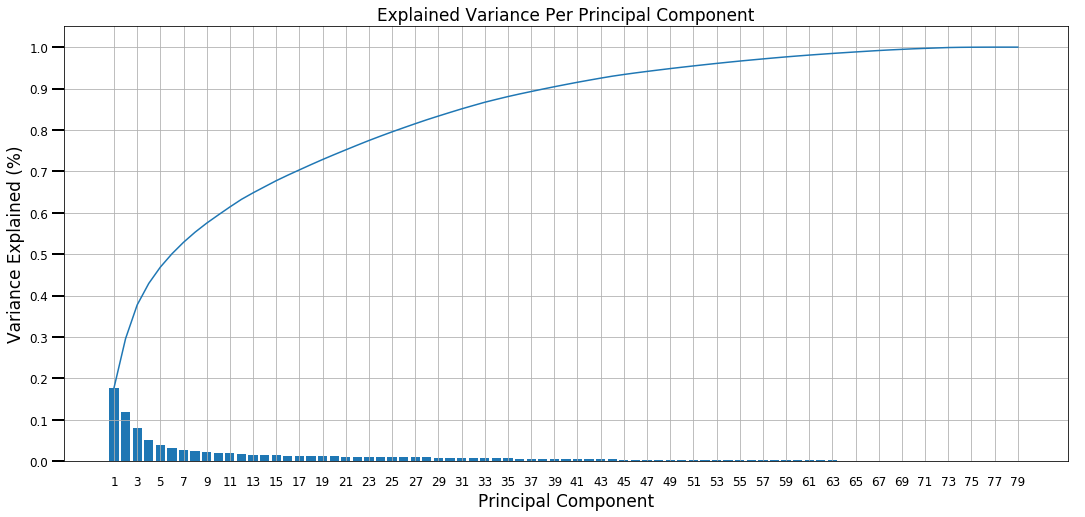

In [41]:
# Investigate the variance accounted for by each principal component.

num_components = len(pca.explained_variance_ratio_)
ind = np.arange(1, num_components+1)
var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(ind, var_ratio)
ax.plot(ind, cum_var_ratio)

ax.xaxis.set_tick_params(width=0, length=10, labelsize=12)
ax.set_xticks(np.arange(1, num_components+1, 2))
ax.yaxis.set_tick_params(width=2, length=12, labelsize=12)
ax.set_yticks(np.linspace(0, 1, num=11))

plt.grid()

ax.set_xlabel("Principal Component", fontsize=17)
ax.set_ylabel("Variance Explained (%)", fontsize=17)
plt.title('Explained Variance Per Principal Component', fontsize=17)

In [42]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=25)
X_pca = pca.fit_transform(subset1_clean_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

We have chosen 25 principal components for furthur analysis. All 25 components together can explain more than 80% of observed variance in the dataset. Also, going beyond the 25 components results in slight increase in explained variance, so I keep first 25 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. We'll use the data dictionary document to help us understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- We should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we should write a function that we can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when we interpret the tendencies of the discovered clusters.

In [43]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def get_weights_sorted(component):
    # -----------------------------------------------------------
    # Function return a dictionary of features and their weights
    # sorted by weights for given component
    
    # Argument: index of intended component
    
    # return : dictionary contains feature and corresponding weights
    # -----------------------------------------------------------
    
    weights = pca.components_[component]
    features = list(subset1_clean.columns)
    features_sorted = [feature for _, feature in sorted(zip(weights, features), reverse=True)]
    weights_sorted = sorted(weights, reverse=True)
    
    feat_dic = res = dict(zip(features_sorted, weights_sorted))

    return feat_dic

In [44]:
get_weights_sorted(0)

{'PLZ8_ANTG3': 0.19719047029567655,
 'CAMEO_DEUG_2015': 0.19296388599547043,
 'PLZ8_ANTG4': 0.19192663825400957,
 'CAMEO_INTL_2015_WEALTH': 0.18961310358479469,
 'PLZ8_BAUMAX': 0.18866882634751198,
 'HH_EINKOMMEN_SCORE': 0.18865867222581925,
 'ORTSGR_KLS9': 0.16658303880710973,
 'EWDICHTE': 0.16311856600412167,
 'FINANZ_HAUSBAUER': 0.14982986919130825,
 'KBA05_ANTG4': 0.13636596668863918,
 'ZABEOTYP': 0.13003766975346193,
 'PLZ8_ANTG2': 0.12972430279502442,
 'ARBEIT': 0.12611602839969741,
 'KBA05_ANTG3': 0.1244731871978699,
 'ANZ_HAUSHALTE_AKTIV': 0.12203163859457621,
 'FINANZ_SPARER': 0.1218224956837296,
 'RELAT_AB': 0.11307676618673831,
 'SEMIO_PFLICHT': 0.090462455964607127,
 'SEMIO_REL': 0.085184428196963771,
 'PRAEGENDE_JUGENDJAHRE_DECADE': 0.083922126173117409,
 'SEMIO_TRADV': 0.079204330925680397,
 'SEMIO_RAT': 0.077098027867089358,
 'SEMIO_MAT': 0.068386341787832886,
 'REGIOTYP': 0.067163828583645724,
 'GEBAEUDETYP': 0.064967574746005188,
 'SEMIO_FAM': 0.062390788182846962,
 'G

In [45]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

get_weights_sorted(1)

{'ALTERSKATEGORIE_GROB': 0.25942460847640381,
 'FINANZ_VORSORGER': 0.22563513851952022,
 'SEMIO_ERL': 0.22547939065050426,
 'SEMIO_LUST': 0.17934452602678597,
 'RETOURTYP_BK_S': 0.16349558277099049,
 'W_KEIT_KIND_HH': 0.11998462640283002,
 'FINANZTYP': 0.1128849597328536,
 'SEMIO_KRIT': 0.11070910907299944,
 'SHOPPER_TYP': 0.10286604658094584,
 'FINANZ_HAUSBAUER': 0.098880451048577345,
 'SEMIO_KAEM': 0.094610832826338601,
 'FINANZ_MINIMALIST': 0.080209590953158175,
 'PLZ8_ANTG3': 0.078015209427492668,
 'ANREDE_KZ': 0.075073674699267734,
 'PLZ8_ANTG4': 0.074968773833310492,
 'ORTSGR_KLS9': 0.074231442779644288,
 'EWDICHTE': 0.073842497075942121,
 'PLZ8_BAUMAX': 0.070969483491751043,
 'WOHNDAUER_2008': 0.059304218160763436,
 'CAMEO_INTL_2015_WEALTH': 0.058920876183301524,
 'ARBEIT': 0.058759087602758019,
 'SEMIO_DOM': 0.05636669376234156,
 'KBA05_ANTG4': 0.055033103302683684,
 'CAMEO_DEUG_2015': 0.054273582889268,
 'RELAT_AB': 0.05238496383504445,
 'PLZ8_ANTG2': 0.049937265755009189,
 'A

In [46]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

get_weights_sorted(2)

{'SEMIO_VERT': 0.34010660312625329,
 'SEMIO_SOZ': 0.26060135607748397,
 'SEMIO_FAM': 0.25493078540421815,
 'SEMIO_KULT': 0.23755024101508765,
 'FINANZ_MINIMALIST': 0.15160473734912674,
 'FINANZTYP': 0.11204572178893378,
 'RETOURTYP_BK_S': 0.10607235695530856,
 'SEMIO_REL': 0.090348750905577591,
 'W_KEIT_KIND_HH': 0.088989866230052214,
 'FINANZ_VORSORGER': 0.081543542974205352,
 'ALTERSKATEGORIE_GROB': 0.06475855996473924,
 'SEMIO_LUST': 0.058969718184739395,
 'SEMIO_MAT': 0.057165542080388307,
 'PRAEGENDE_JUGENDJAHRE_MOVEMENT': 0.051658656314037134,
 'GREEN_AVANTGARDE': 0.051658656314037134,
 'PLZ8_BAUMAX': 0.051385915577493932,
 'ORTSGR_KLS9': 0.050115518549750347,
 'PLZ8_ANTG4': 0.04857636048255267,
 'EWDICHTE': 0.048539057464457115,
 'PLZ8_ANTG3': 0.046894951547525682,
 'LP_STATUS_GROB': 0.038492645148101245,
 'ARBEIT': 0.036938182281800035,
 'RELAT_AB': 0.031007811072131394,
 'WOHNDAUER_2008': 0.030028949552260348,
 'PLZ8_ANTG2': 0.028724093273696877,
 'KBA05_ANTG4': 0.027805505806

### Discussion 2.3: Interpret Principal Components

We can see that the features with high weights in the first component mostly represent the type of buildings(how many +6 family houses within the plz8 region) and the wealth. Since they have a positive correlation, by looking at the definition of features, we can say rich and wealthy people are more likely to live in regions with houses for families with low members.

The second principal component mainly represents age along with some personality and financial typology. By looking at the highest and lowest weights, we can say generally younger people tend to have a lower affinity for religion and be less prepared financially wise. On the other hand, the older generation is more likely traditional-minded and money-saver.

Moreover, the third principal component encapsulates information regarding gender and some personality typology. On the positive side of this component, we would probably have males with more combative, dominant, critical-minded, and rational-minded attitudes; and on the negative side, we would probably have females with more social-minded, family-minded, and cultural-minded attitudes.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. We can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. We should test for cluster counts through at least 10 clusters to get the full picture, but we shouldn't need to test for a number of clusters above about 30.
- Once we've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation.

In [47]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
num_clusters = np.arange(1, 16, 1)

def get_within_cluster_dis(num_cluster):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=num_cluster)
    model = kmeans.fit(X_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(X_pca))
    
    return score

In [48]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []

for num_cluster in num_clusters:
    scores.append(get_within_cluster_dis(num_cluster))

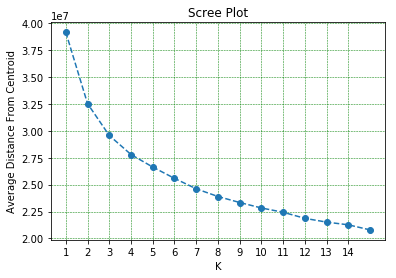

In [49]:
plt.plot(num_clusters, scores, linestyle='--', marker='o')
plt.xlabel('K')
plt.xticks(range(1,15))
plt.ylabel('Average Distance From Centroid')
plt.title('Scree Plot')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.show()

In [72]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=4, random_state=42)
model = kmeans.fit(X_pca)
pred_labels_general = model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

We've chosen 4 clusters to segment the population since there is no considerable decrease in average distance when we have more than 4 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, we're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, we will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function we created earlier. (We can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, we should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should we be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [51]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [52]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

subset1_customers_clean, subset2_customers = clean_data(customers)
#customers_cleaned = customers_cleaned.dropna(axis=0)

#scaler = StandardScaler()
subset1_customers_clean_scaled = scaler.transform(subset1_customers_clean)
X_pca_customers = pca.transform(subset1_customers_clean_scaled)

pred_labels_customers = model.predict(X_pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis we performed in step 1.1.3 of the project, where we separated out certain data points from the dataset if they had more than a specified threshold of missing values. If we found that this group was qualitatively different from the main bulk of the data, we should treat this as an additional data cluster in this analysis. Make sure that we account for the number of data points in this subset, for both the general population and customer datasets, when making our computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help making this inference. Alternatively, we can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [73]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_len = len(subset1_clean) + len(subset2)
customers_len = len(subset1_customers_clean) + len(subset2_customers)
n_clusters = 4
proportion_general = {}
proportion_customers = {}

for i in range(n_clusters):
    proportion_general[f'cluster{i+1}'] = len(pred_labels_general[pred_labels_general == i]) / general_len * 100.00
    proportion_customers[f'cluster{i+1}'] = len(pred_labels_customers[pred_labels_customers == i]) / customers_len * 100.00
    
proportion_general['cluster5'] = len(subset2) / general_len * 100.00
proportion_customers['cluster5'] = len(subset2_customers) / customers_len * 100.00

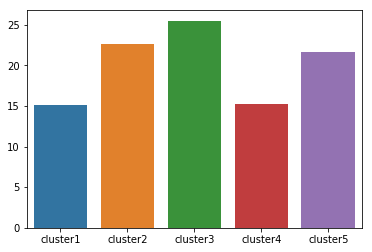

In [74]:
sns.barplot(x=list(proportion_general.keys()), y=list((proportion_general.values())))

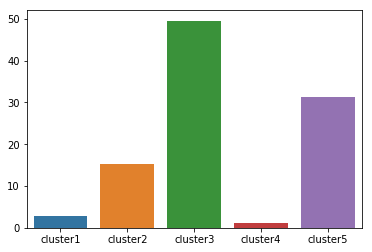

In [75]:
sns.barplot(x=list(proportion_customers.keys()), y=list(proportion_customers.values()))

In [76]:
columns = []
for i in range(1,26):
    columns.append(f'principal_component_{i}')

principalDf_general = pd.DataFrame(data = X_pca, columns = columns)
principalDf_customers = pd.DataFrame(data = X_pca_customers, columns = columns)

In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster3_index_customers = np.where(pred_labels_customers==2)
df_cluster3 = principalDf_customers.iloc[cluster3_index_customers]
df_cluster3.head()

,principal_component_1,principal_component_2,principal_component_3,principal_component_4,principal_component_5,principal_component_6,principal_component_7,principal_component_8,principal_component_9,principal_component_10,...,principal_component_16,principal_component_17,principal_component_18,principal_component_19,principal_component_20,principal_component_21,principal_component_22,principal_component_23,principal_component_24,principal_component_25
0,-6.644752,0.838475,3.600402,0.866601,-2.807016,0.313562,2.687297,-1.089154,1.470912,-0.224975,...,1.079684,0.064833,-0.172343,-0.032880,0.092608,-0.457027,-1.572663,0.490176,-0.311049,-0.439153
1,-1.922108,4.849652,-0.588716,2.438041,-1.433836,-1.331405,-1.424057,1.097088,0.468578,-0.508128,...,0.099313,-0.162844,-0.176600,-0.896013,-1.642245,1.242759,1.045021,0.870602,-1.090726,0.496399
3,-2.691839,1.308406,2.896162,2.387852,-2.455220,0.526240,0.077253,-1.740305,-1.635234,-0.685119,...,0.452769,1.277065,-0.104851,1.336732,-0.828825,0.490064,0.364833,-0.188170,-1.420781,-0.896962
4,-6.451248,0.413473,2.838633,0.174574,-2.167725,0.245983,1.779891,-0.446738,-0.308070,0.636110,...,-0.193394,1.882534,-0.356034,0.346626,0.134181,-0.105705,-0.181894,-0.615996,0.472635,-0.087363
5,-5.514166,1.654699,4.077789,2.005253,-1.262216,-1.854461,0.501265,-0.520499,2.569384,-0.078678,...,0.668506,-0.444761,-0.056254,0.392739,-0.027023,0.839702,-0.368706,-1.273958,-0.638493,0.001450


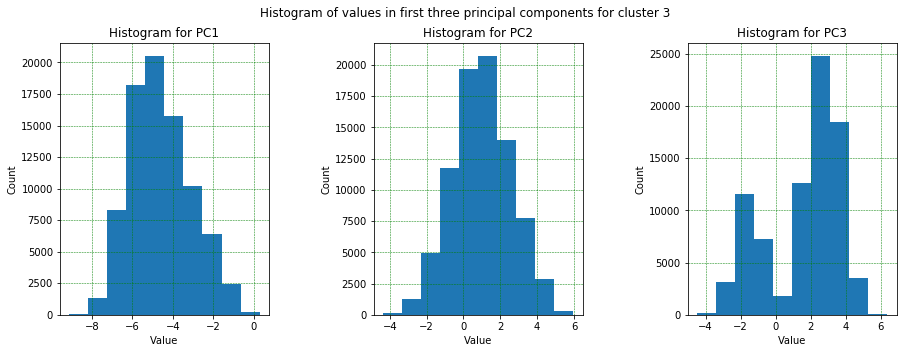

In [78]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Histogram of values in first three principal components for cluster 3')

for i in range(3):
   
    axs[i].hist(df_cluster3[f'principal_component_{i+1}'])
    axs[i].set_title(f'Histogram for PC{i+1}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Count')
    axs[i].grid(color = 'green', linestyle = '--', linewidth = 0.5)

plt.subplots_adjust(wspace=0.5)
plt.show()

In [79]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster4_index_customers = np.where(pred_labels_customers==3)
df_cluster4 = principalDf_customers.iloc[cluster4_index_customers]
df_cluster4.head()

,principal_component_1,principal_component_2,principal_component_3,principal_component_4,principal_component_5,principal_component_6,principal_component_7,principal_component_8,principal_component_9,principal_component_10,...,principal_component_16,principal_component_17,principal_component_18,principal_component_19,principal_component_20,principal_component_21,principal_component_22,principal_component_23,principal_component_24,principal_component_25
2,1.250883,-1.373754,1.102727,0.666466,1.790513,3.907434,-1.316201,-0.162755,0.925588,-0.628518,...,0.212915,0.023982,-0.025816,0.025946,-0.722618,-1.495224,-0.034971,1.436426,-0.813164,0.015496
13,6.563399,-1.578334,2.939763,1.219504,0.106908,0.008307,-0.231254,2.323526,1.274107,-0.415061,...,0.330057,0.347463,-0.106419,-0.333729,0.095084,1.955808,-0.080237,0.407656,-0.108820,-1.520745
56,1.750398,-1.860396,3.487876,3.159439,-0.832773,-0.542580,-0.124690,-0.993327,1.907791,0.617370,...,2.395101,1.127590,-0.169972,0.509406,-0.399360,-0.484305,-0.451449,-0.368052,-0.337352,-0.262915
80,6.445904,1.462678,-0.021714,0.635634,1.086217,-1.339032,2.828979,0.331731,-0.824767,4.780831,...,-1.257138,0.938251,-0.246124,-0.287768,-0.573015,-1.230750,0.445903,-0.370428,-0.009221,-0.549511
86,6.043502,-3.016981,3.513547,0.659939,2.392793,-1.478607,3.266292,0.693127,-1.623236,0.408659,...,-0.713812,-0.451956,-0.082188,-0.784312,-0.057799,-1.552704,0.003434,-1.282348,0.999171,-0.844411


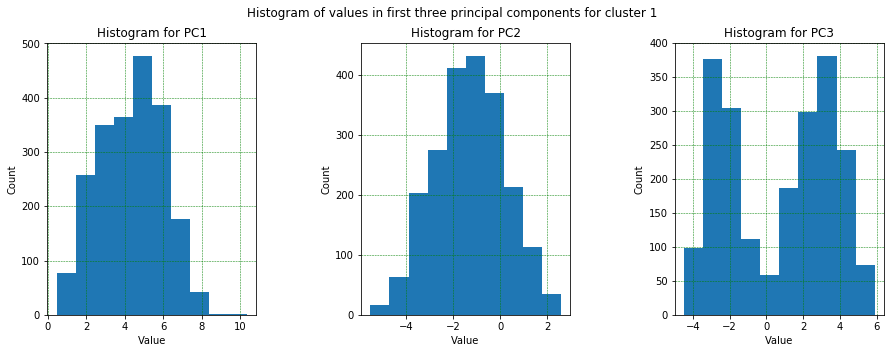

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Histogram of values in first three principal components for cluster 1')

for i in range(3):
   
    axs[i].hist(df_cluster4[f'principal_component_{i+1}'])
    axs[i].set_title(f'Histogram for PC{i+1}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Count')
    axs[i].grid(color = 'green', linestyle = '--', linewidth = 0.5)

plt.subplots_adjust(wspace=0.5)
plt.show()

By comparing the proportion of persons in each cluster, we can clearly see that cluster 3 is overrepresented in the customer data; however, clusters 1,2, and 4 are underrepresented. In addition, the distribution of values in the first three principal components is plotted to investigate the type of people in these clusters.

Cluster 3 which is the target audience for the company mostly has a negative value for PC1. It means the customers in this cluster generally are from the upper class and in a good financial situation. Moreover, the second PC for this group is mostly around zero and slightly tends to be on the positive side which means we would have a slightly older population in this group. Also, the third PC shows us the distribution of males and females in this cluster. We can say that there are more males than females in this cluster. Cluster 3 actually represents the segment of the population that is relatively popular with the mail-order company.

For the underrepresented clusters like cluster 4, we can see that they usually have a positive value for PC1 which indicates that they are relatively poorer and live in regions that have buildings for families with higher members. Also, PC2 for this cluster has generally negative value which represents the younger generation and corresponding personal and financial typology. We have seen that the younger generation has lower religion affinity but they are more event-oriented and sensual-minded. The PC3 in this cluster is quite symmetric which means the distribution of males and females in these clusters is quite symmetric.